In [3]:
import pandas as pd
from sqlalchemy import create_engine

# PostgreSQL connection details
postgres_user = 'postgres'
postgres_password = ''
postgres_host = 'localhost'
postgres_port = '5432'
postgres_db = 'football'

# Create a PostgreSQL connection using SQLAlchemy
postgres_uri = f'postgresql://{postgres_user}:{postgres_password}@{postgres_host}:{postgres_port}/{postgres_db}'
engine = create_engine(postgres_uri)
df=pd.read_sql_table('combined_data_features', engine)
# View the data
print(df.head())


         Date        Round Venue Result  GF  GA Opponent  xG_x  xGA  Poss  \
0  2023-08-11  Matchweek 1  Away      W   3   0  Burnley   1.9  0.3    65   
1  2023-08-11  Matchweek 1  Away      W   3   0  Burnley   1.9  0.3    65   
2  2023-08-11  Matchweek 1  Away      W   3   0  Burnley   1.9  0.3    65   
3  2023-08-11  Matchweek 1  Away      W   3   0  Burnley   1.9  0.3    65   
4  2023-08-11  Matchweek 1  Away      W   3   0  Burnley   1.9  0.3    65   

   ... early_goals team_pass_ratio  passes_per_game  defensive_work_rate  \
0  ...           1        0.818182         0.236842                  0.0   
1  ...           1        0.818182         0.236842                  0.0   
2  ...           0        0.818182         0.236842                  0.0   
3  ...           0        0.818182         0.236842                  0.0   
4  ...           1        0.818182         0.236842                  0.0   

   formation_width  opponent_formation_width  average_position_x  \
0           

In [4]:
# Check the first few rows of the dataset
df.head()

# Get summary statistics
df.describe()

# Check data types and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 113 entries, Date to goals_before_15
dtypes: float64(46), int64(46), object(21)
memory usage: 159.9+ KB


In [5]:
# Check for missing values
df.isnull().sum()


df.fillna(0,inplace=True)

df.isnull().sum()


# Check percentage of missing data for each column
missing_data = df.isnull().mean().sort_values(ascending=False)
print(missing_data[missing_data > 0])



Series([], dtype: float64)


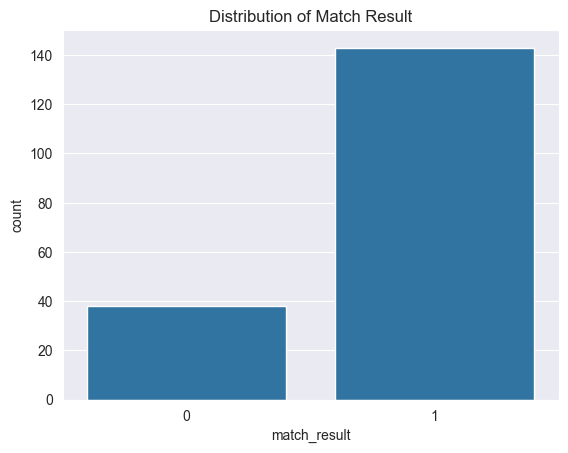

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
sns.countplot(x='match_result', data=df)
plt.title('Distribution of Match Result')
plt.show()


In [7]:
from sklearn.preprocessing import LabelEncoder

# Convert Date column to numeric (days since the first match)
df['Date'] = pd.to_datetime(df['Date'])
df['days_since_first_match'] = (df['Date'] - df['Date'].min()).dt.days

# Convert Round in Matchweek 1
df['Round'] = df['Round'].str.extract('(\d+)').astype(int)

# Function to split the formation into defenders, midfielders, and forwards
def parse_formation(formation):
    parts = formation.split('-')
    # Ensure that there are always 3 parts (defense, midfield, attack)
    return [int(part) for part in parts] if len(parts) == 3 else [0, 0, 0]

# Apply the function to both 'Formation' and 'Opp Formation' columns
df[['defenders', 'midfielders', 'forwards']] = pd.DataFrame(df['Formation'].apply(parse_formation).tolist(), index=df.index)
df[['defenders_opp', 'midfielders_opp', 'forwards_opp']] = pd.DataFrame(df['Opp Formation'].apply(parse_formation).tolist(), index=df.index)

# Drop the original formation columns if needed
df = df.drop(columns=['Formation', 'Opp Formation'])

# Drop the original Date column
df.drop(columns=['Date','player_assisted','Assist','time','opponent'], inplace=True)


# Function to handle the minute conversion
def convert_minute(minute):
    if '+' in str(minute):  # Handle cases like '45+1', '90+5'
        base, added_time = minute.split('+')
        return int(base) + int(added_time)  # Add base minute and extra time
    else:  # Handle regular minutes
        return int(minute)

# Apply the function to the 'Minute' column
df['Minute'] = df['Minute'].apply(convert_minute)


df=df.rename(columns={
    'result':'shot_result'
})


# List of categorical columns to encode
categorical_columns = ['Venue', 'Opponent', 'player', 'Result', 'situation', 'shotType', 'Goalkeeper', 'squad', 'season', 'lastAction','Body Part','Notes','shot_result']

# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\khadk\AppData\Local\Temp\ipykernel_8116\2818488763.py:8: SyntaxWarning: invalid escape sequence '\d'
  df['Round'] = df['Round'].str.extract('(\d+)').astype(int)
C:\Users\khadk\AppData\Local\Temp\ipykernel_8116\2818488763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['defenders_opp', 'midfielders_opp', 'forwards_opp']] = pd.DataFrame(df['Opp Formation'].apply(parse_formation).tolist(), index=df.index)
C:\Users\khadk\AppData\Local\Temp\ipykernel_8116\2818488763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

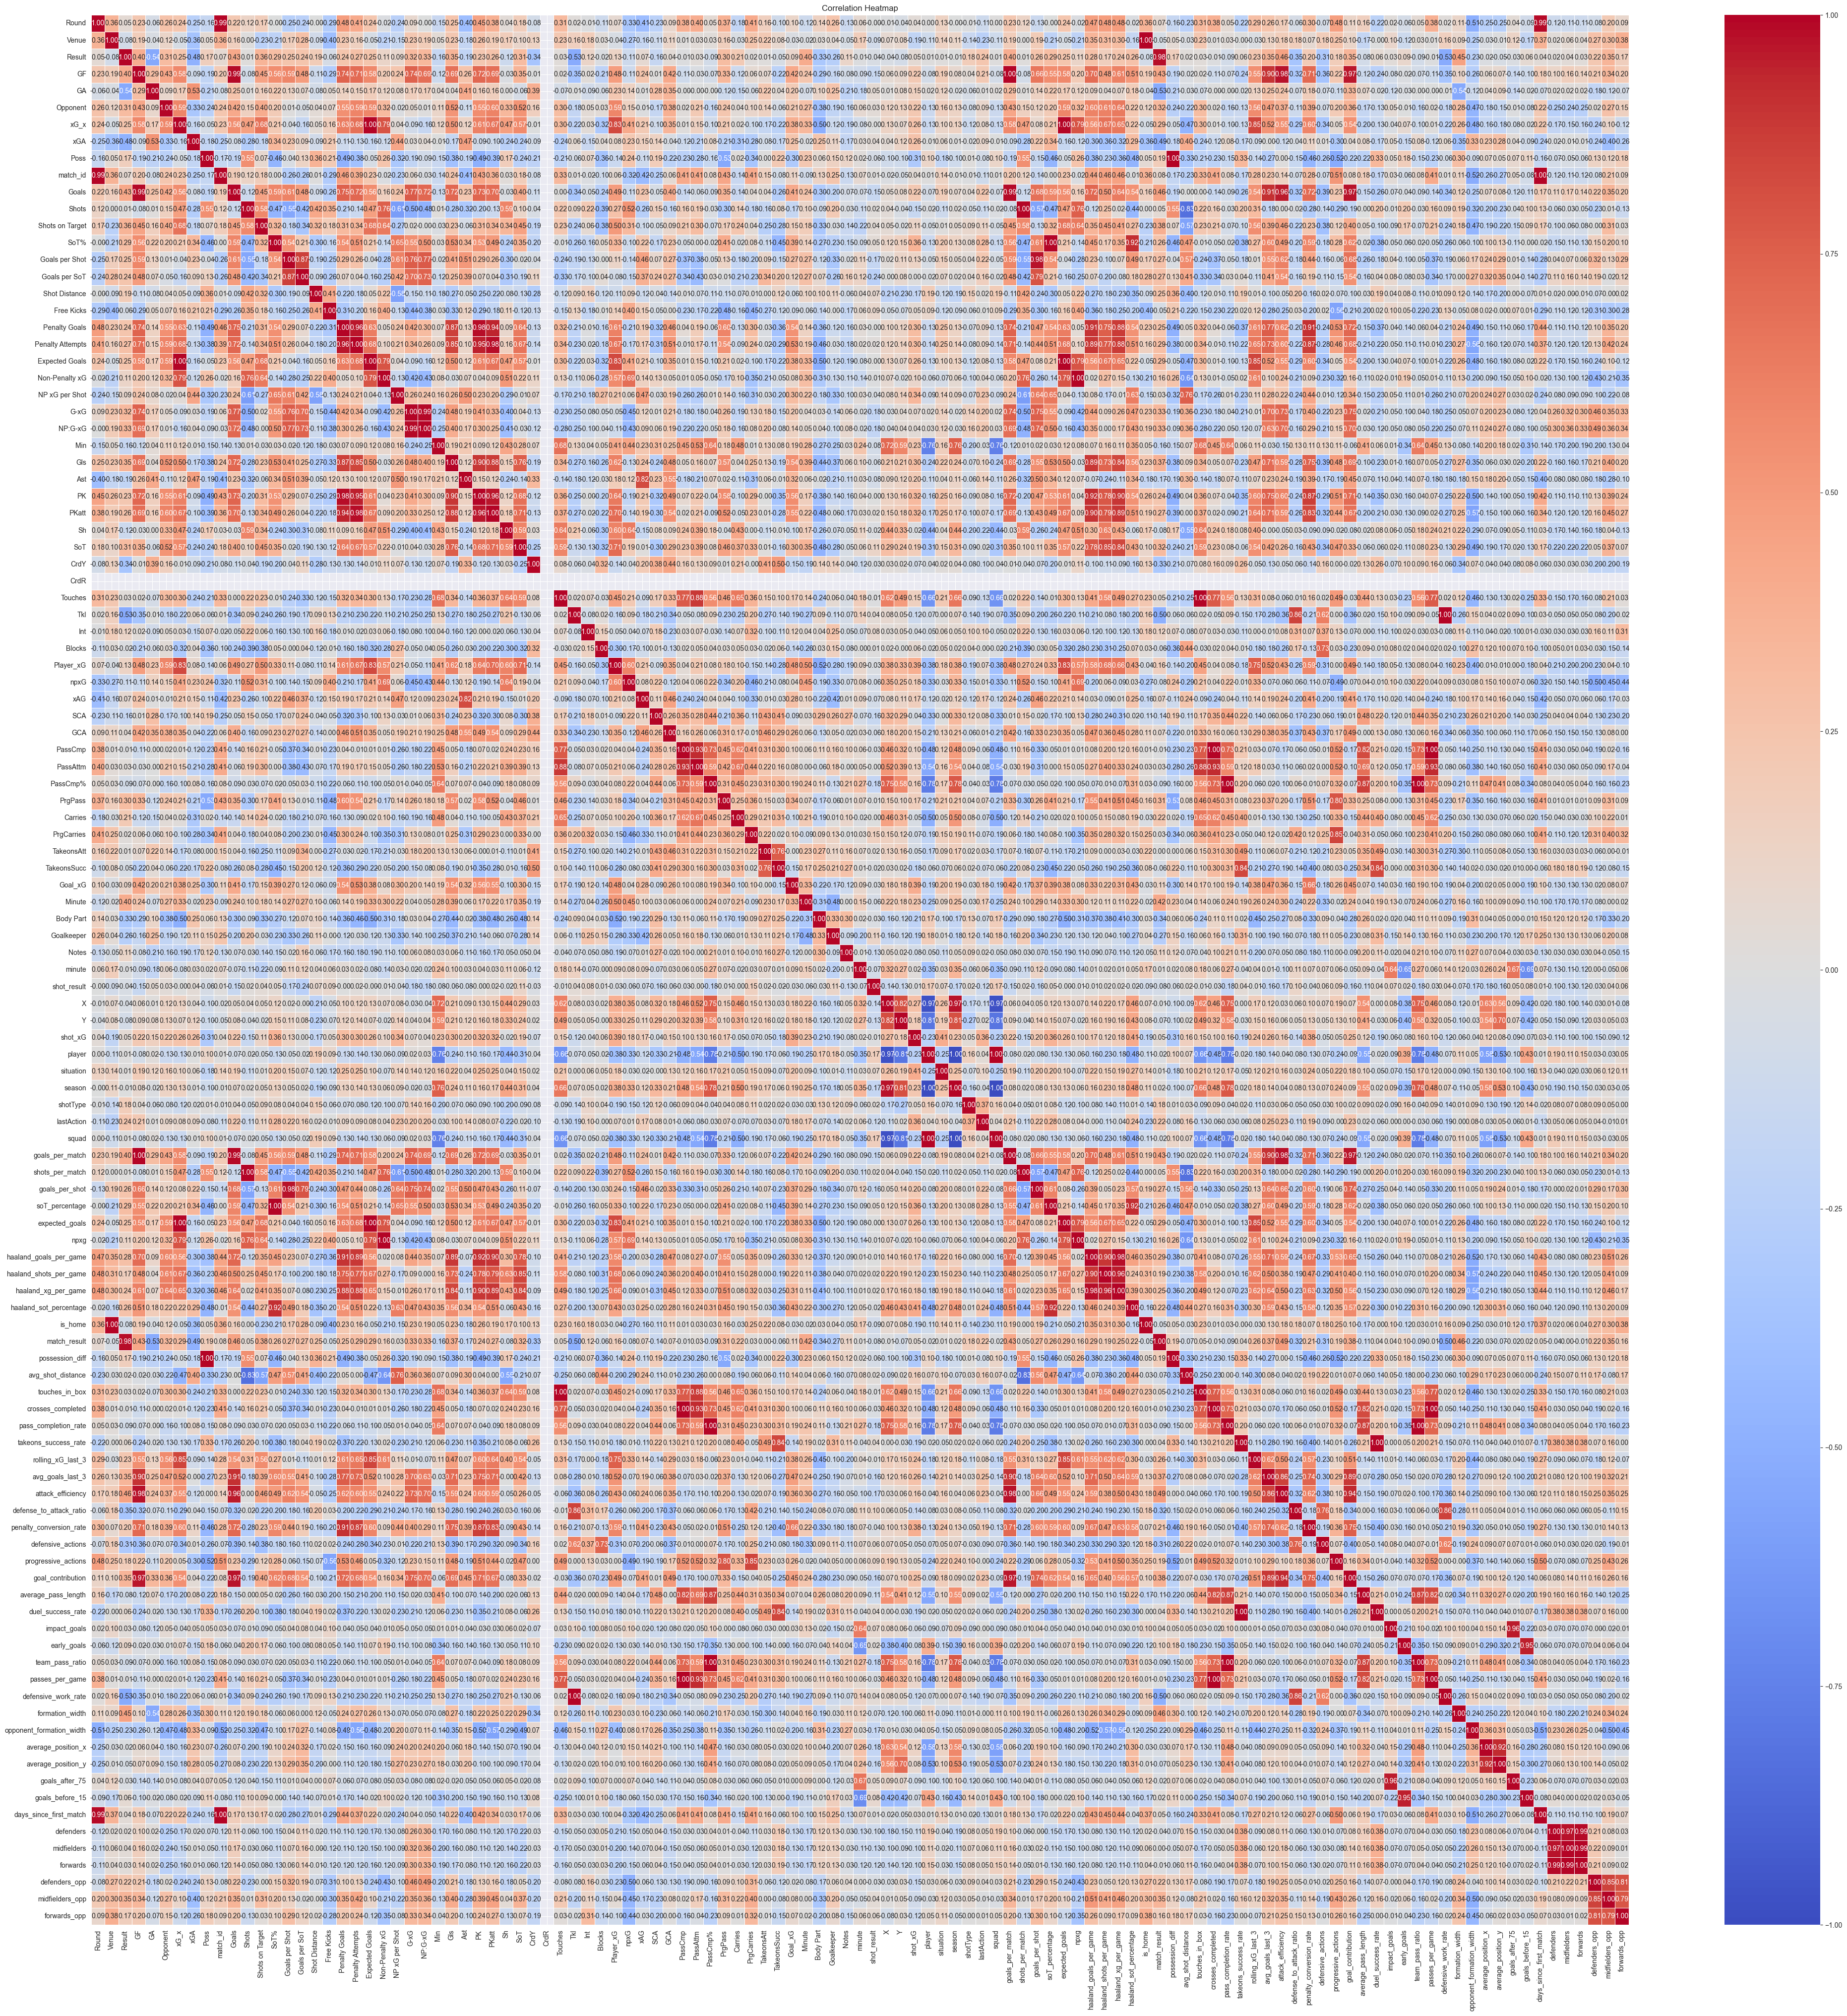

In [8]:

# Change whole None to 0
df = df.replace('None', 0)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of correlations
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



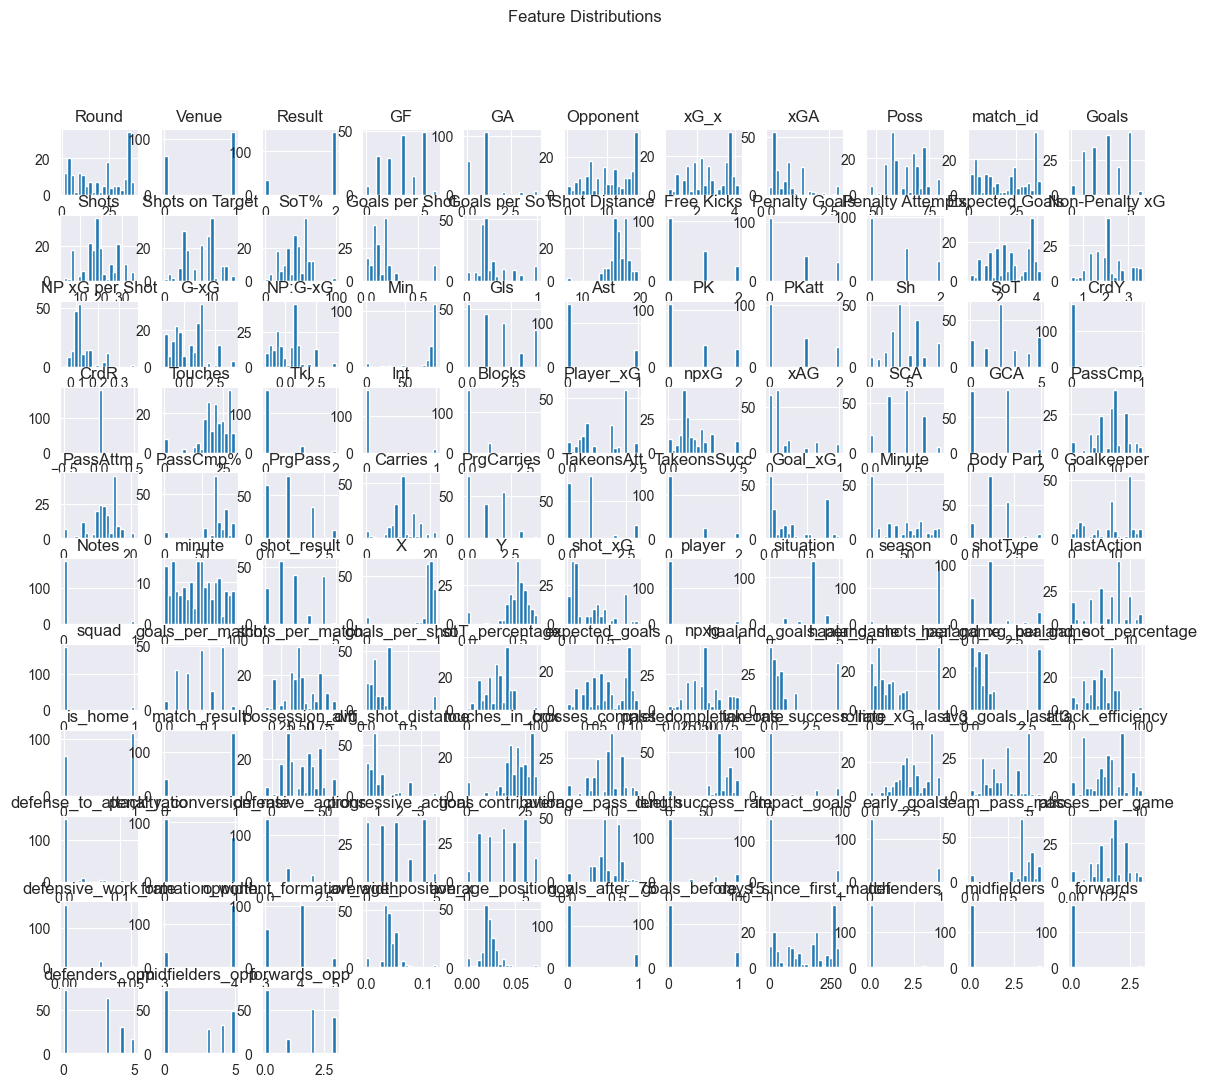

In [9]:
# Plot histograms for numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

df[numerical_columns].hist(figsize=(14, 12), bins=20)
plt.suptitle('Feature Distributions')
plt.show()


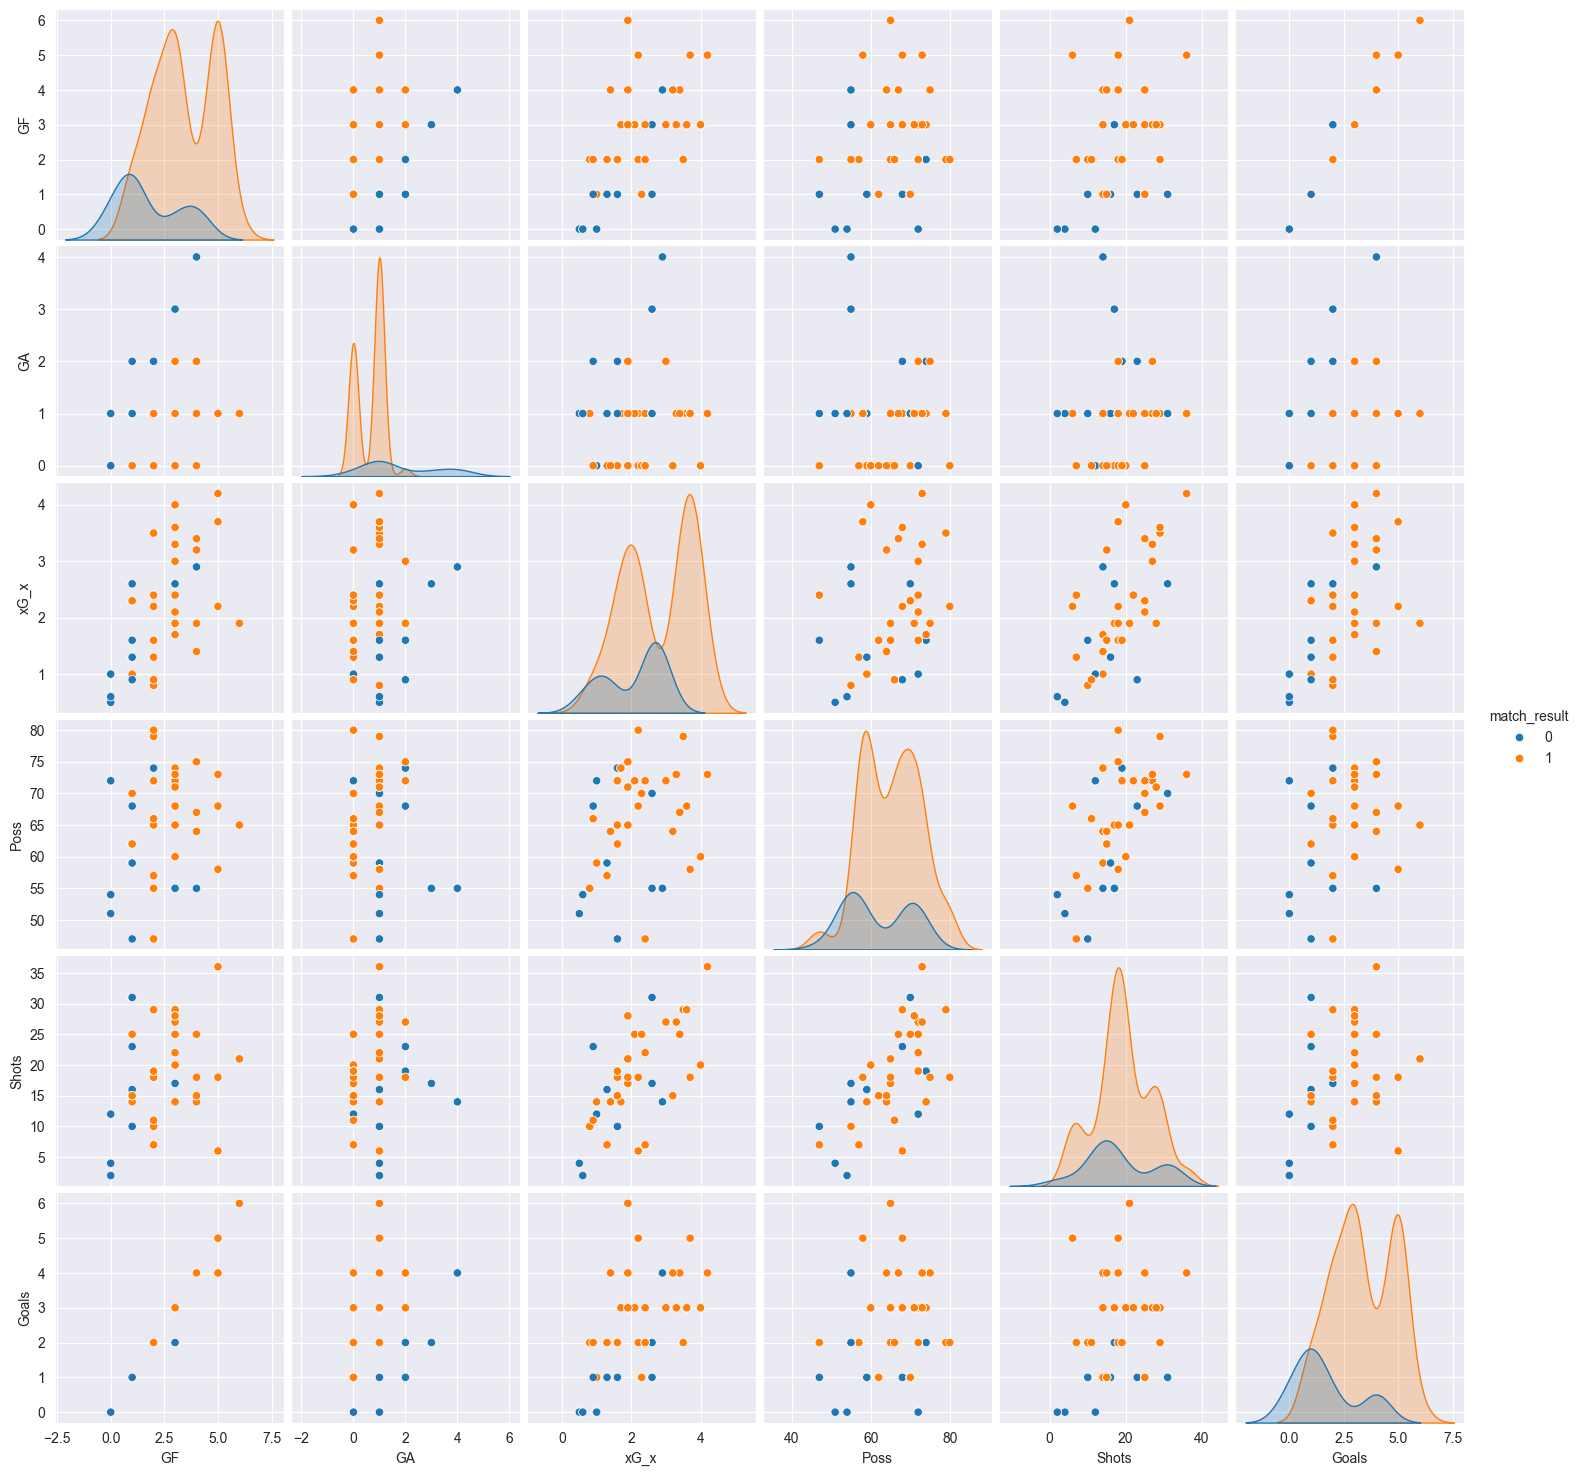

In [12]:
# Pairplot to visualize relationships between selected features
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['GF', 'GA', 'xG_x', 'Poss', 'Shots', 'Goals', 'match_result']], hue='match_result')
plt.show()



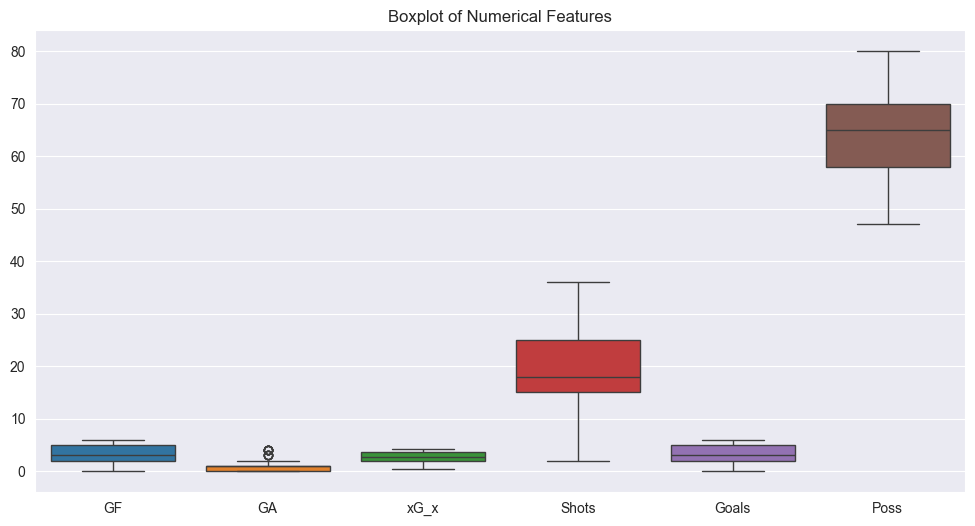

In [13]:
# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['GF', 'GA', 'xG_x', 'Shots', 'Goals', 'Poss']])
plt.title('Boxplot of Numerical Features')
plt.show()
 

In [14]:
# Countplot for categorical features
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Simple model to check feature importance
X = df.drop(columns=['match_result'])
y = df['match_result']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(X.columns, importances)
plt.title('Feature Importances')
plt.show()


TypeError: Feature names are only supported if all input features have string names, but your input has ['quoted_name', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.